<a href="https://colab.research.google.com/github/Ghisbe/Alertas_pictogramas/blob/main/Modelo_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redes neuronales recurrentes.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import Word2Vec
import gdown


Utilizamos dos csv de el pre procesamiento de la columna 'description' e 'instruction' para combinar ambas columnas.

In [4]:
url = "https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu"

In [5]:
output = 'alertas_lemma.csv'
gdown.download(url, output, quiet=False)

# Leer el archivo CSV en un DataFrame de pandas
alertas_description = pd.read_csv(output)

Downloading...
From (original): https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu
From (redirected): https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu&confirm=t&uuid=fc58204a-9c83-491d-bb34-715a259870f7
To: /content/alertas_lemma.csv
100%|██████████| 143M/143M [00:01<00:00, 78.9MB/s]


In [6]:
alertas_description.head(2)

,id,event,description,instruction,urgency,severity,description_token,description_no_stopwords,lemmatized_description
0,5ed30eb3283336e2e7c8a2a8,Dust Storm Warning,the national weather service in phoenix has is...,Motorists should not drive into a dust storm. ...,Expected,Severe,"['the', 'national', 'weather', 'service', 'in'...","['national', 'weather', 'service', 'phoenix', ...","['national', 'weather', 'service', 'phoenix', ..."
1,5e6daf2c023f1930efa590ce,Tropical Storm Warning,what winds thirty to forty kt and seas five t...,Mariners should alter plans to avoid these haz...,Immediate,Severe,"['what', 'winds', 'thirty', 'to', 'forty', 'kt...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi..."


In [7]:
# descargamos el otro dataset con el procesamiento de 'instruction'
url_instruction = "https://drive.google.com/uc?id=1E2QjfTk4Ke6u1ZEnmsqWHETproJE5zVK"
output_instruction = 'archivo_instruction.csv'
gdown.download(url_instruction, output_instruction, quiet=False)

# Leer el archivo CSV de instruction
instructions = pd.read_csv(output_instruction)

Downloading...
From: https://drive.google.com/uc?id=1E2QjfTk4Ke6u1ZEnmsqWHETproJE5zVK
To: /content/archivo_instruction.csv
100%|██████████| 13.9M/13.9M [00:00<00:00, 246MB/s]


In [8]:
instructions.head(2)

,id,event,instruction_token2
0,5ed30eb3283336e2e7c8a2a8,Dust Storm Warning,"['motorist', 'drive', 'dust', 'storm', 'pull',..."
1,5e6daf2c023f1930efa590ce,Tropical Storm Warning,"['mariner', 'alter', 'plan', 'avoid', 'hazardo..."


Unimos los dataframe teniendo en cuanta el ID.

In [9]:
alertas = pd.merge(alertas_description, instructions, on='id')

In [10]:
# Combinar las columnas lematizadas y de instrucciones en una única columna
alertas['combined_text'] = alertas['lemmatized_description'].apply(lambda x: ' '.join(eval(x))) + ' ' + alertas['instruction']

In [11]:
alertas.head(2)

,id,event_x,description,instruction,urgency,severity,description_token,description_no_stopwords,lemmatized_description,event_y,instruction_token2,combined_text
0,5ed30eb3283336e2e7c8a2a8,Dust Storm Warning,the national weather service in phoenix has is...,Motorists should not drive into a dust storm. ...,Expected,Severe,"['the', 'national', 'weather', 'service', 'in'...","['national', 'weather', 'service', 'phoenix', ...","['national', 'weather', 'service', 'phoenix', ...",Dust Storm Warning,"['motorist', 'drive', 'dust', 'storm', 'pull',...",national weather service phoenix issued dust s...
1,5e6daf2c023f1930efa590ce,Tropical Storm Warning,what winds thirty to forty kt and seas five t...,Mariners should alter plans to avoid these haz...,Immediate,Severe,"['what', 'winds', 'thirty', 'to', 'forty', 'kt...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi...",Tropical Storm Warning,"['mariner', 'alter', 'plan', 'avoid', 'hazardo...",winds thirty forty kt seas five eight ft south...


In [12]:
# Tokenización y padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(alertas['combined_text'])
sequences = tokenizer.texts_to_sequences(alertas['combined_text'])
max_len = 200
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

In [13]:
# Word Embeddings
sentences = [text.split() for text in alertas['combined_text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, epochs=10)

Visualizar la distribucion de etiquetas.

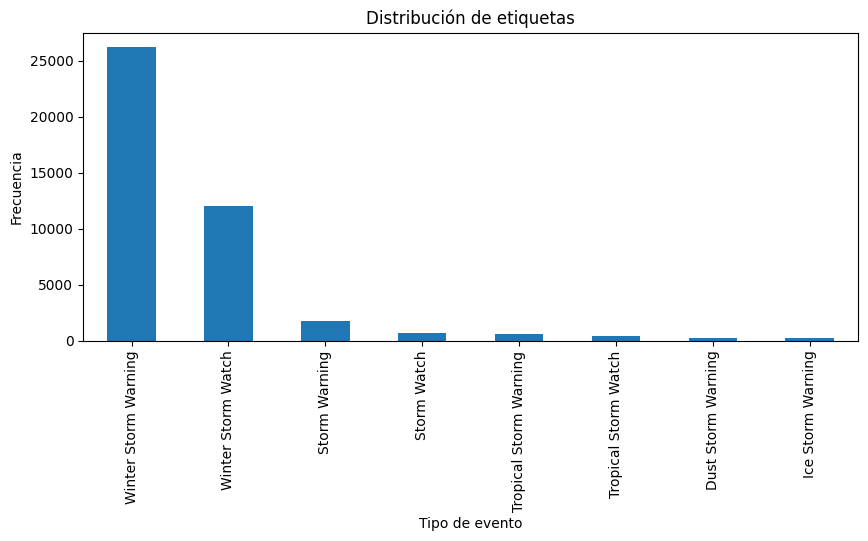

In [14]:
plt.figure(figsize=(10, 4))
alertas['event_x'].value_counts().plot(kind='bar')
plt.title('Distribución de etiquetas')
plt.xlabel('Tipo de evento')
plt.ylabel('Frecuencia')
plt.show()

In [15]:
# Revisión de la consistencia de etiquetas
grupo_evento = alertas.groupby('event_x')
for event, group in grupo_evento:
    print(f"Evento: {event}")
    print(group['combined_text'].head(5))
    print("\n")

Evento: Dust Storm Warning
0     national weather service phoenix issued dust s...
52    national weather service el paso issued dust s...
62    national weather service spokane issued dust s...
63    national weather service spokane issued dust s...
64    national weather service spokane issued dust s...
Name: combined_text, dtype: object


Evento: Ice Storm Warning
5150    significant icing expected total snow accumula...
6093    ice storm warning cancelled longer effect A Wi...
6107    ice storm warning cancelled longer effect A Wi...
6109    significant icing expected total snow accumula...
6153    significant icing expected total snow accumula...
Name: combined_text, dtype: object


Evento: Storm Warning
76     southwest winds fifteen twenty-five kt gusts t...
77     storm warning south winds fifty kts gusts seve...
252    storm warning cancelled longer effect Mariners...
253    storm warning cancelled longer effect Mariners...
255    storm warning cancelled longer effect Mariners

Detectar anomalias.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest

In [17]:
# Convertir descripciones a representaciones numéricas usando TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(alertas['combined_text'])

# Aplicar Isolation Forest para detectar anomalías
clf = IsolationForest(contamination=0.01, random_state=42)
alertas['anomaly'] = clf.fit_predict(X)

# Revisar las anomalías detectadas
anomalies = alertas[alertas['anomaly'] == -1]
print("Anomalías detectadas:")
print(anomalies[['combined_text', 'event_x']])

Anomalías detectadas:
                                           combined_text               event_x
1787   heavy snow strong winds impact northcentral no...  Winter Storm Warning
4367   winter weather warnings advisories extended tu...  Winter Storm Warning
5077   winter weather advisory snow sleet expected to...    Winter Storm Watch
8111   moderate heavy snow expected saturday evening ...    Winter Storm Watch
8582   light moderate snow falling currently colorado...    Winter Storm Watch
...                                                  ...                   ...
41367  strong shear exacting toll guillermo new infor...  Tropical Storm Watch
41372  hilda gradually weakening drawing closer hawai...  Tropical Storm Watch
41494  ignacio rapidly intensifies major hurricane ne...  Tropical Storm Watch
41633  tropical storm niala moving northwestward new ...  Tropical Storm Watch
42050  strong northeasterly gradient place across gre...         Storm Warning

[421 rows x 2 columns]


Eliminar las anomalias.

In [18]:
# Eliminar las filas con anomalías del DataFrame
alertas_cleaned = alertas[alertas['anomaly'] != -1]

print(f"Total de filas después de eliminar anomalías: {len(alertas_cleaned)}")

Total de filas después de eliminar anomalías: 41655


Division de datos para el entrenamiento y validacion.

In [19]:
# Dividir los datos en entrenamiento y validación
train_features, val_features, train_labels, val_labels = train_test_split(
    padded_sequences, alertas['event_x'], test_size=0.2, random_state=42
)

In [20]:
print("Cantidad de datos de entrenamiento:", len(train_features))
print("Cantidad de datos de validación:", len(val_features))

Cantidad de datos de entrenamiento: 33660
Cantidad de datos de validación: 8416


In [21]:
# Codificar las etiquetas
label_encoder_event = LabelEncoder()
train_labels = label_encoder_event.fit_transform(train_labels)
val_labels = label_encoder_event.transform(val_labels)

In [22]:
# Construcción del modelo
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,
                    weights=[embedding_matrix], trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(128, dropout=0.3, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(alertas['event_x'].unique()), activation='softmax'))


In [23]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          957800    
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 1083824 (4.13 MB)
Trainable params: 126024 (492.28 KB)
Non-trainable params: 957800 (3.65 MB)
______________

In [25]:
# Entrenamiento del modelo
history = model.fit(train_features, np.array(train_labels),
                    validation_data=(val_features, np.array(val_labels)),
                    epochs=20, batch_size=16)

Epoch 1/20
2104/2104 [==============================] - 29s 11ms/step - loss: 0.6667 - accuracy: 0.7753 - val_loss: 0.3986 - val_accuracy: 0.8939
Epoch 2/20
2104/2104 [==============================] - 26s 12ms/step - loss: 0.3381 - accuracy: 0.8963 - val_loss: 0.2295 - val_accuracy: 0.9308
Epoch 3/20
2104/2104 [==============================] - 23s 11ms/step - loss: 0.2338 - accuracy: 0.9258 - val_loss: 0.1865 - val_accuracy: 0.9457
Epoch 4/20
2104/2104 [==============================] - 23s 11ms/step - loss: 0.1867 - accuracy: 0.9443 - val_loss: 0.1492 - val_accuracy: 0.9573
Epoch 5/20
2104/2104 [==============================] - 26s 13ms/step - loss: 0.1568 - accuracy: 0.9539 - val_loss: 0.1262 - val_accuracy: 0.9620
Epoch 6/20
2104/2104 [==============================] - 23s 11ms/step - loss: 0.1215 - accuracy: 0.9622 - val_loss: 0.0876 - val_accuracy: 0.9724
Epoch 7/20
2104/2104 [==============================] - 24s 11ms/step - loss: 0.1004 - accuracy: 0.9650 - val_loss: 0.0774 -

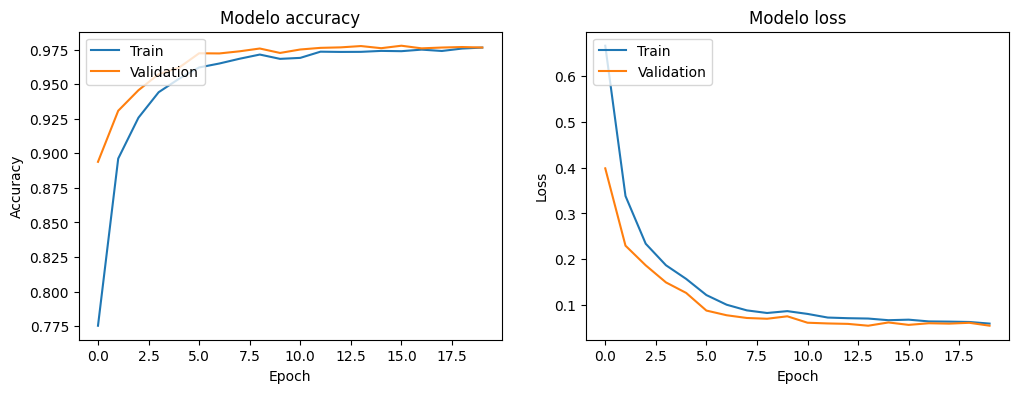

In [26]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
# Evaluación del modelo
loss, accuracy = model.evaluate(val_features, np.array(val_labels))
print(f'Loss: {loss}, Accuracy: {accuracy}')


263/263 [==============================] - 2s 5ms/step - loss: 0.0546 - accuracy: 0.9766
Loss: 0.05455052852630615, Accuracy: 0.9765921831130981


In [28]:
# Matriz de confusión y reporte de clasificación
val_predictions = model.predict(val_features)
val_predictions = np.argmax(val_predictions, axis=1)
cm = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(cm)


263/263 [==============================] - 1s 4ms/step
Confusion Matrix:
[[  44    0    0    0    0    1    0    0]
 [   0   48    0    0    0    0    3    0]
 [   1    0  382    2    5    0    0    0]
 [   0    0    2  114    0    0    0    0]
 [   0    0    5    0  102    2    1    0]
 [   0    0    0    1    3   62    0    0]
 [   0    2    0    0    0    0 5147  126]
 [   0    0    0    0    0    0   43 2320]]


In [29]:
print("Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=label_encoder_event.classes_))

Classification Report:
                        precision    recall  f1-score   support

    Dust Storm Warning       0.98      0.98      0.98        45
     Ice Storm Warning       0.96      0.94      0.95        51
         Storm Warning       0.98      0.98      0.98       390
           Storm Watch       0.97      0.98      0.98       116
Tropical Storm Warning       0.93      0.93      0.93       110
  Tropical Storm Watch       0.95      0.94      0.95        66
  Winter Storm Warning       0.99      0.98      0.98      5275
    Winter Storm Watch       0.95      0.98      0.96      2363

              accuracy                           0.98      8416
             macro avg       0.96      0.96      0.96      8416
          weighted avg       0.98      0.98      0.98      8416



Prediccion con en relacion a la descripcion y el evento.

In [30]:
# Función predict
def predict(texts, tokenizer, model, max_len, eventos):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    predictions = model.predict(padded_sequences)
    predicted_events = [eventos[np.argmax(prediction)] for prediction in predictions]
    return predicted_events


In [31]:
# Función random_prediction
def random_prediction(alertas, n=1, tokenizer=None, model=None, max_len=None):
    # Extraer eventos únicos directamente del DataFrame
    eventos = alertas['event_x'].unique()

    random_indices = np.random.choice(alertas.index, size=n, replace=False)  # Seleccionar índices aleatorios
    random_descriptions = alertas.loc[random_indices, 'combined_text'].values  # Usar la columna combined_text
    predictions = predict(random_descriptions, tokenizer, model, max_len, eventos)
    result = list(zip(random_descriptions, predictions))  # Emparejar descripciones y predicciones
    return result

In [32]:
# Llamar a la función random_prediction
predictions = random_prediction(alertas, n=1, tokenizer=tokenizer, model=model, max_len=max_len)
for combined_text, prediction in predictions:
    print(f'Description: {combined_text}')
    print(f'Prediction: {prediction}')

1/1 [==============================] - 0s 360ms/step
Description: heavy snow blowing snow occurring visibility less one half mile times plan difficult travel conditions additional snow accumulations one inch expected lower yukon valley noon today additional details winds gusting high forty mph cause areas blowing drifting snow A Winter Storm Warning for blowing snow means severe winter
weather conditions are occurring. This will make travel very
difficult or impossible.


Prediction: Storm Watch


#Creacion de pictogramas.

Un pictograma es un símbolo gráfico que transmite información o datos mediante una representación clara y simplificada ya que, ayudan a transmitir información de forma visual y más rápida.

Se utiliza OpenCV. Ademas, se cargan imagenes relacionadas con eventos meteorologicos, y se les hace un preproceso para ajustar la imagen, ademas se le agregan elementos como el triangulo de las advertencias para indicar la vigilancia o adverencia del evento.

In [53]:
import cv2
from google.colab.patches import cv2_imshow

In [60]:
def crear_pictograma(description, event):
    # Determinar la ruta de la imagen según el tipo de alerta
    if 'Dust Storm Warning' in event:
        ruta_imagen = '/content/drive/MyDrive/Iconos/dust storm.png'
        triangulo_color = (0, 0, 255, 255)  # Rojo con alfa completo
    elif 'Tropical Storm Warning' in event:
        ruta_imagen = '/content/drive/MyDrive/Iconos/tormenta-tropical.png'
        triangulo_color = (0, 0, 255, 255)  # Rojo con alfa completo
    elif 'Winter Storm Warning' in event:
        ruta_imagen = '/content/drive/MyDrive/Iconos/winter storm.png'
        triangulo_color = (0, 0, 255, 255)  # Rojo con alfa completo
    elif 'Storm Warning' in event:
        ruta_imagen = '/content/drive/MyDrive/Iconos/storm.png'
        triangulo_color = (0, 0, 255, 255)  # Rojo con alfa completo
    elif 'Ice Storm Warning' in event:
        ruta_imagen = '/content/drive/MyDrive/Iconos/ice storm.png'
        triangulo_color = (0, 0, 255, 255)  # Rojo con alfa completo
    elif 'Tropical Storm Watch' in event:
        ruta_imagen = '/content/drive/MyDrive/Iconos/tormenta-tropical.png'
        triangulo_color = (0, 255, 255, 255)  # Amarillo con alfa completo
    elif 'Winter Storm Watch' in event:
        ruta_imagen = '/content/drive/MyDrive/Iconos/winter storm.png'
        triangulo_color = (0, 255, 255, 255)  # Amarillo con alfa completo
    elif 'Storm Watch' in event:
        ruta_imagen = '/content/drive/MyDrive/Iconos/storm.png'
        triangulo_color = (0, 255, 255, 255)  # Amarillo con alfa completo


    # Cargar la imagen base del pictograma
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_UNCHANGED)
     # Verificar si la imagen se cargó correctamente
    if imagen is None:
        print("Error: No se pudo cargar la imagen desde la ruta:", ruta_imagen)
        return None

    # Crear una máscara del mismo tamaño que la imagen y rellenarla con blanco
    mascara_blanca = np.ones_like(imagen) * 255

    # Convertir la imagen a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Aplicar umbralización para obtener una máscara
    _, mascara = cv2.threshold(gris, 200, 255, cv2.THRESH_BINARY)

    # Encontrar contornos en la máscara
    contornos, _ = cv2.findContours(mascara, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dibujar los contornos en la máscara blanca
    cv2.drawContours(mascara_blanca, contornos, -1, (0, 0, 0), -1)

    # Pintar las regiones de interés de color celeste en la imagen original
    for cnt in contornos:
        cv2.fillPoly(imagen, [cnt], (173, 216, 230))

    # Coordenadas del triángulo (ajústalas según sea necesario)
    p1 = (90, 50)
    p2 = (200, 150)
    p3 = (0, 150)

    # Dibujar el triángulo en la imagen del icono
    cv2.drawContours(imagen, [np.array([p1, p2, p3])], 0, triangulo_color, -1)

    # Coordenadas para colocar el símbolo de exclamación (ajústalas según sea necesario)
    posicion_exclamacion = (75, 140)  # Posición del centro del símbolo de exclamación

    # Tamaño de la fuente para el símbolo de exclamación
    tamano_fuente = 3

    # Dibujar el símbolo de exclamación en color negro con un tamaño de fuente más grande
    cv2.putText(imagen, '!', posicion_exclamacion, cv2.FONT_HERSHEY_SIMPLEX, tamano_fuente, (0, 0, 0), 5, cv2.LINE_AA)

    # Devolver la imagen generada
    return imagen

Descripción: heavy snow possible plan difficult travel conditions total snow accumulations four inches amounts thirteen inches seven thousand feet possible san bernardino riverside san diego county mountains five thousand feet monday evening tuesday morning snow levels start five thousand , five hundred feet monday evening lower around three thousand , five hundred feet tuesday morning additional details significant reductions visibility possible A Winter Storm Watch means there is potential for significant
snow, sleet or ice accumulations that may impact travel. Continue
to monitor the latest forecasts.
Evento: Winter Storm Watch


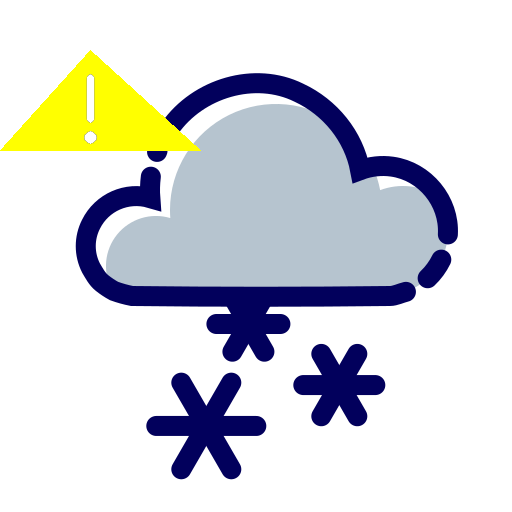

In [108]:
def generar_pictograma_desde_indice(indice):
    # Obtener la descripción y el evento para el índice proporcionado
    description = alertas.iloc[indice]['combined_text']
    event = alertas.iloc[indice]['event_x']

    # Imprimir la descripción y el evento para verificar
    print("Descripción:", description)
    print("Evento:", event)

    # Generar el pictograma para el evento y la descripción
    pictograma = crear_pictograma(description, event)
    return pictograma

# Índice del evento que deseas visualizar
indice_evento = 1984

# Generar el pictograma para el índice dado
pictograma = generar_pictograma_desde_indice(indice_evento)

# Mostrar el pictograma
cv2_imshow(pictograma)